Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import neurokit2 as nk
from collections import Counter
from scipy import signal
from scipy.fft import fft, fftfreq
import wfdb
import warnings
import os

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


Load ECG Dataset

In [2]:
def load_ecg_data(record_id='08219'):
    """
    Load ECG data dari MIT-BIH AF database
    """
    try:
        record = wfdb.rdrecord(record_id, pn_dir='afdb')
        ecg_signal = record.p_signal[:, 0]  # Lead 1 only
        fs = record.fs
        
        print(f"✓ Record {record_id} loaded successfully")
        print(f"  Signal length: {len(ecg_signal):,} samples")
        print(f"  Duration: {len(ecg_signal)/fs/60:.1f} minutes")
        print(f"  Sampling frequency: {fs} Hz")
        
        return ecg_signal, fs, record_id
        
    except Exception as e:
        print(f"❌ Error loading record {record_id}: {e}")
        return None, None, None

# Load data
record_id = '08219'  # Define record ID
ecg_signal, fs, record_id = load_ecg_data(record_id)

if ecg_signal is not None:
    processed_ecg = ecg_signal.copy()
    processed_fs = fs
    print(f"\n✅ Data loaded and ready for processing")
else:
    print("❌ Failed to load data")

✓ Record 08219 loaded successfully
  Signal length: 9,205,760 samples
  Duration: 613.7 minutes
  Sampling frequency: 250 Hz

✅ Data loaded and ready for processing


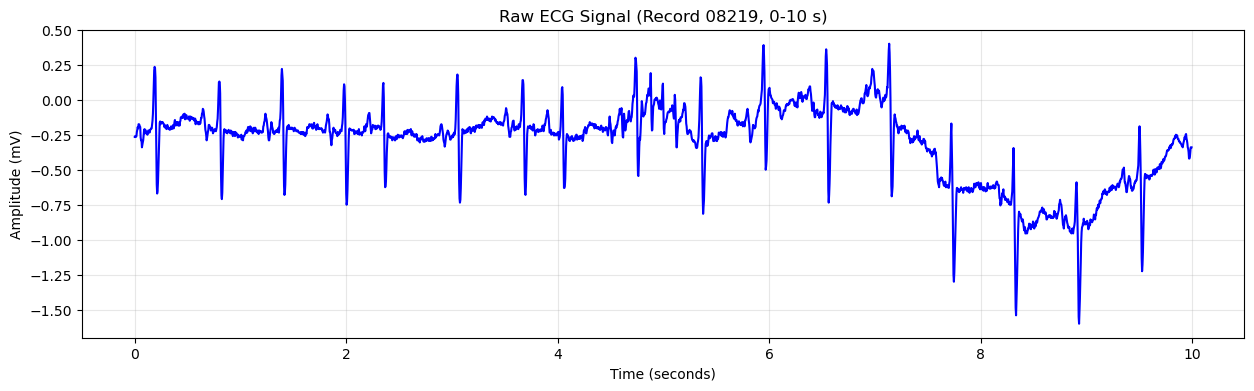

In [3]:
if ecg_signal is not None:

    # Tentukan segment waktu untuk plot (misal 0-10 detik)
    start_time = 0    # detik
    end_time   = 10   # detik
    start_sample = int(start_time * fs)
    end_sample   = int(end_time * fs)

    ecg_segment = ecg_signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    plt.figure(figsize=(15, 4))
    plt.plot(time_axis, ecg_segment, color='b')
    plt.title(f"Raw ECG Signal (Record {record_id}, {start_time}-{end_time} s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.show()


Apply Filtering

In [4]:
def apply_comprehensive_filtering(ecg_signal, fs):
    """
    Apply comprehensive filtering: DC removal + Bandpass + Notch
    """
    print("=== Applying Comprehensive Filtering ===")
    
    # Step 1: DC removal
    ecg_dc_removed = ecg_signal - np.mean(ecg_signal)
    print(f"✓ DC offset removed (mean was: {np.mean(ecg_signal):.4f})")
    
    # Step 2: Bandpass filter (0.5-40 Hz)
    nyquist = fs / 2
    low_cutoff = 0.5 / nyquist
    high_cutoff = 40.0 / nyquist
    
    bp_b, bp_a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    ecg_bandpass = signal.filtfilt(bp_b, bp_a, ecg_dc_removed)
    print("✓ Bandpass filter applied (0.5-40 Hz)")
    
    # Step 3: Notch filter (50 Hz)
    notch_freq = 50.0 / nyquist
    notch_b, notch_a = signal.iirnotch(notch_freq, Q=25)
    ecg_filtered = signal.filtfilt(notch_b, notch_a, ecg_bandpass)
    print("✓ Notch filter applied (50 Hz)")
    
    # Quality check
    print(f"\nFiltering Results:")
    print(f"  Original - Mean: {np.mean(ecg_signal):.4f}, Std: {np.std(ecg_signal):.4f}")
    print(f"  Filtered - Mean: {np.mean(ecg_filtered):.4f}, Std: {np.std(ecg_filtered):.4f}")
    
    return ecg_filtered

# Apply filtering
if ecg_signal is not None:
    filtered_ecg = apply_comprehensive_filtering(processed_ecg, processed_fs)
    print("\n✅ Filtering completed successfully")

=== Applying Comprehensive Filtering ===
✓ DC offset removed (mean was: 0.0274)
✓ Bandpass filter applied (0.5-40 Hz)
✓ Notch filter applied (50 Hz)

Filtering Results:
  Original - Mean: 0.0274, Std: 0.1945
  Filtered - Mean: 0.0000, Std: 0.1098

✅ Filtering completed successfully


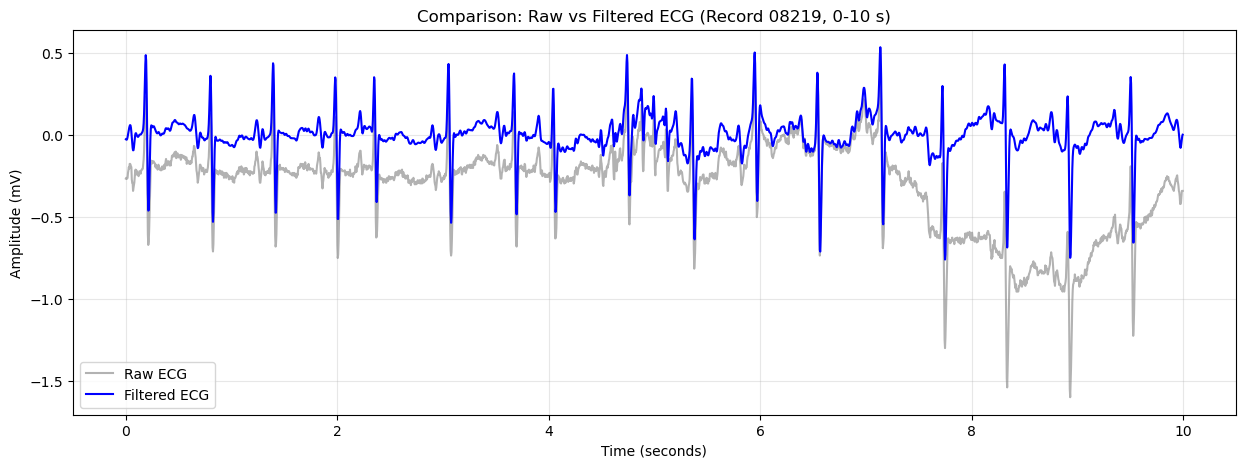

In [5]:
if ecg_signal is not None and filtered_ecg is not None:

    # Tentukan segment waktu untuk plot (misal 0-10 detik)
    start_time = 0    # detik
    end_time   = 10   # detik
    start_sample = int(start_time * fs)
    end_sample   = int(end_time * fs)

    raw_segment = ecg_signal[start_sample:end_sample]
    filtered_segment = filtered_ecg[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time_axis, raw_segment, label='Raw ECG', color='gray', alpha=0.6)
    plt.plot(time_axis, filtered_segment, label='Filtered ECG', color='b')
    plt.title(f"Comparison: Raw vs Filtered ECG (Record {record_id}, {start_time}-{end_time} s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Load and Process Annotations

In [6]:
def load_and_process_annotations(record_id):
    """
    Load dan process rhythm annotations
    """
    try:
        annotation = wfdb.rdann(record_id, 'atr', pn_dir='afdb')
        
        if hasattr(annotation, 'aux_note') and annotation.aux_note is not None:
            rhythm_labels = [label.strip() for label in annotation.aux_note]
            print(f"✓ Found {len(rhythm_labels)} rhythm annotations")
            
            # Count labels
            label_counts = Counter(rhythm_labels)
            print("Rhythm distribution:")
            for label, count in label_counts.most_common():
                print(f"  {label}: {count} ({count/len(rhythm_labels)*100:.1f}%)")
            
            annotation.rhythm_labels = rhythm_labels
            return annotation, label_counts
        else:
            print("❌ No detailed rhythm labels found")
            return None, None
            
    except Exception as e:
        print(f"❌ Error loading annotations: {e}")
        return None, None

# Load annotations
annotations, label_counts = load_and_process_annotations(record_id)

✓ Found 79 rhythm annotations
Rhythm distribution:
  (N: 40 (50.6%)
  (AFIB: 39 (49.4%)


AF & Normal Segments

In [7]:
def extract_af_normal_segments(ecg_signal, annotations, fs):
    """
    Extract hanya segments AF dan Normal
    """
    if annotations is None:
        print("No annotations available")
        return None, None, None
    
    print("=== Extracting AF/Normal Segments ===")
    
    # Define categories
    af_labels = {'(AFIB', 'AFIB'}
    normal_labels = {'(N', 'N', 'NSR'}
    
    rhythm_labels = annotations.rhythm_labels
    
    # Classify annotations
    af_indices = [i for i, label in enumerate(rhythm_labels) if label in af_labels]
    normal_indices = [i for i, label in enumerate(rhythm_labels) if label in normal_labels]
    
    print(f"AF annotations: {len(af_indices)}")
    print(f"Normal annotations: {len(normal_indices)}")
    
    if not af_indices and not normal_indices:
        print("No AF or Normal annotations found")
        return None, None, None
    
    # Create segments
    keep_indices = sorted(af_indices + normal_indices)
    segments = []
    clean_signal_parts = []
    clean_labels = []
    
    for i in range(len(keep_indices) - 1):
        current_idx = keep_indices[i]
        next_idx = keep_indices[i + 1]
        
        start_sample = annotations.sample[current_idx]
        end_sample = annotations.sample[next_idx]
        current_rhythm = rhythm_labels[current_idx]
        
        # Binary label assignment
        binary_label = 1 if current_rhythm in af_labels else 0
        label_type = "AF" if binary_label == 1 else "NORMAL"
        
        # Extract signal segment
        if end_sample <= len(ecg_signal):
            signal_segment = ecg_signal[start_sample:end_sample]
            clean_signal_parts.append(signal_segment)
            clean_labels.append(binary_label)
            
            duration = (end_sample - start_sample) / fs
            segments.append({
                'start_sample': start_sample,
                'end_sample': end_sample,
                'duration_sec': duration,
                'label': binary_label,
                'rhythm_label': current_rhythm
            })
            
            print(f"Segment {len(segments):2d}: {current_rhythm} -> {label_type} ({duration:.1f}s)")
    
    # Concatenate segments
    if clean_signal_parts:
        clean_ecg = np.concatenate(clean_signal_parts)
        clean_labels = np.array(clean_labels)
        
        print(f"\n=== Extraction Results ===")
        print(f"Clean signal: {len(clean_ecg):,} samples")
        print(f"AF segments: {np.sum(clean_labels == 1)}")
        print(f"Normal segments: {np.sum(clean_labels == 0)}")
        print(f"Data retention: {len(clean_ecg)/len(ecg_signal)*100:.1f}%")
        
        return clean_ecg, clean_labels, segments
    else:
        return None, None, None

# Extract AF/Normal segments
if filtered_ecg is not None and annotations is not None:
    clean_ecg, clean_labels, segments = extract_af_normal_segments(
        filtered_ecg, annotations, processed_fs
    )

=== Extracting AF/Normal Segments ===
AF annotations: 39
Normal annotations: 40
Segment  1: (N -> NORMAL (12311.0s)
Segment  2: (AFIB -> AF (195.6s)
Segment  3: (N -> NORMAL (72.3s)
Segment  4: (AFIB -> AF (366.2s)
Segment  5: (N -> NORMAL (143.8s)
Segment  6: (AFIB -> AF (402.5s)
Segment  7: (N -> NORMAL (50.7s)
Segment  8: (AFIB -> AF (422.9s)
Segment  9: (N -> NORMAL (170.9s)
Segment 10: (AFIB -> AF (235.4s)
Segment 11: (N -> NORMAL (42.9s)
Segment 12: (AFIB -> AF (243.5s)
Segment 13: (N -> NORMAL (60.7s)
Segment 14: (AFIB -> AF (536.3s)
Segment 15: (N -> NORMAL (41.0s)
Segment 16: (AFIB -> AF (70.2s)
Segment 17: (N -> NORMAL (51.2s)
Segment 18: (AFIB -> AF (77.8s)
Segment 19: (N -> NORMAL (2238.2s)
Segment 20: (AFIB -> AF (414.8s)
Segment 21: (N -> NORMAL (29.2s)
Segment 22: (AFIB -> AF (101.0s)
Segment 23: (N -> NORMAL (47.0s)
Segment 24: (AFIB -> AF (348.9s)
Segment 25: (N -> NORMAL (30.2s)
Segment 26: (AFIB -> AF (130.9s)
Segment 27: (N -> NORMAL (35.9s)
Segment 28: (AFIB -> AF 

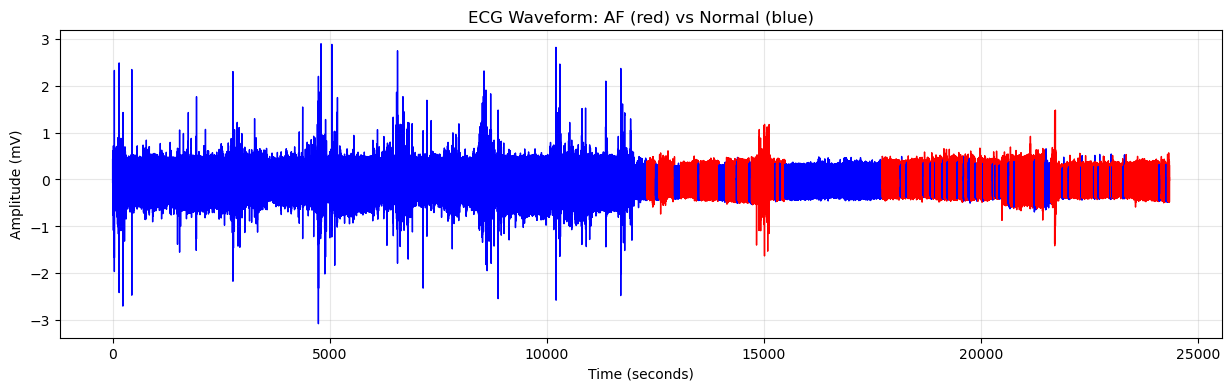

In [8]:
if clean_ecg is not None and segments is not None:
    plt.figure(figsize=(15, 4))
    
    current_pos = 0
    for seg in segments:
        start = current_pos
        end = start + (seg['end_sample'] - seg['start_sample'])
        label = seg['label']
        
        # Pilih warna: AF = red, Normal = blue
        color = 'r' if label == 1 else 'b'
        plt.plot(np.arange(start, end)/processed_fs, 
                 clean_ecg[start:end], 
                 color=color, linewidth=1)
        
        current_pos = end  # update posisi untuk concatenated signal
    
    plt.title("ECG Waveform: AF (red) vs Normal (blue)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.show()

Segmentasi -> Fixed-Length Windows

In [9]:
def create_ecg_windows(ecg_signal, segments, fs, window_length_sec=10, overlap_ratio=0.5):
    """
    Create fixed-length ECG windows untuk BiLSTM training
    
    Parameters:
    -----------
    ecg_signal : array
        Clean ECG signal (concatenated AF/Normal segments)
    segments : list
        Segment information dengan labels
    fs : int
        Sampling frequency
    window_length_sec : float
        Window length dalam detik
    overlap_ratio : float
        Overlap ratio antar windows (0-1)
    """
    
    print(f"=== Creating ECG Windows ===")
    print(f"Window length: {window_length_sec} seconds")
    print(f"Overlap ratio: {overlap_ratio}")
    
    window_samples = int(window_length_sec * fs)
    step_samples = int(window_samples * (1 - overlap_ratio))
    
    windows = []
    window_labels = []
    
    # Create windows dengan sliding approach
    current_pos = 0
    
    for seg in segments:
        seg_length = seg['end_sample'] - seg['start_sample']
        seg_end_pos = current_pos + seg_length
        
        # Create windows dalam segment ini
        seg_start = current_pos
        
        while seg_start + window_samples <= seg_end_pos:
            # Extract window
            window = ecg_signal[seg_start:seg_start + window_samples]
            
            windows.append(window)
            window_labels.append(seg['label'])
            
            seg_start += step_samples
        
        current_pos = seg_end_pos
    
    windows = np.array(windows)
    window_labels = np.array(window_labels)
    
    print(f"\nWindow creation results:")
    print(f"  Total windows: {len(windows)}")
    print(f"  Window shape: {windows.shape}")
    print(f"  AF windows: {np.sum(window_labels == 1)} ({np.sum(window_labels == 1)/len(window_labels)*100:.1f}%)")
    print(f"  Normal windows: {np.sum(window_labels == 0)} ({np.sum(window_labels == 0)/len(window_labels)*100:.1f}%)")
    
    return windows, window_labels

# Create ECG windows
if clean_ecg is not None and segments is not None:
    ecg_windows, window_labels = create_ecg_windows(
        clean_ecg, 
        segments, 
        processed_fs, 
        window_length_sec=10,  # 10-second windows
        overlap_ratio=0.5      # 50% overlap
    )
    print("\n✅ ECG windows created successfully")
else:
    print("❌ Error: clean_ecg or segments not found!")
    print("Please run previous cells first")

=== Creating ECG Windows ===
Window length: 10 seconds
Overlap ratio: 0.5

Window creation results:
  Total windows: 4753
  Window shape: (4753, 2500)
  AF windows: 1532 (32.2%)
  Normal windows: 3221 (67.8%)

✅ ECG windows created successfully


Normalisasi

In [10]:
def normalize_ecg_windows(windows, method='zscore'):
    """
    Normalize ECG windows untuk neural network
    """
    print(f"=== Normalizing ECG Windows ===")
    print(f"Method: {method}")
    print(f"Original data range: {np.min(windows):.3f} - {np.max(windows):.3f}")
    
    if method == 'zscore':
        # Z-score normalization per window
        normalized_windows = []
        for window in windows:
            if np.std(window) > 0:  # Avoid division by zero
                normalized = (window - np.mean(window)) / np.std(window)
            else:
                normalized = window - np.mean(window)
            normalized_windows.append(normalized)
        normalized_windows = np.array(normalized_windows)
        
    elif method == 'minmax':
        # Global min-max normalization
        global_min = np.min(windows)
        global_max = np.max(windows)
        normalized_windows = (windows - global_min) / (global_max - global_min)
    
    print(f"Normalized data range: {np.min(normalized_windows):.3f} - {np.max(normalized_windows):.3f}")
    print("✓ Normalization completed")
    
    return normalized_windows

# Normalize windows
normalized_windows = normalize_ecg_windows(ecg_windows, method='zscore')

=== Normalizing ECG Windows ===
Method: zscore
Original data range: -3.072 - 2.892
Normalized data range: -11.014 - 12.395
✓ Normalization completed


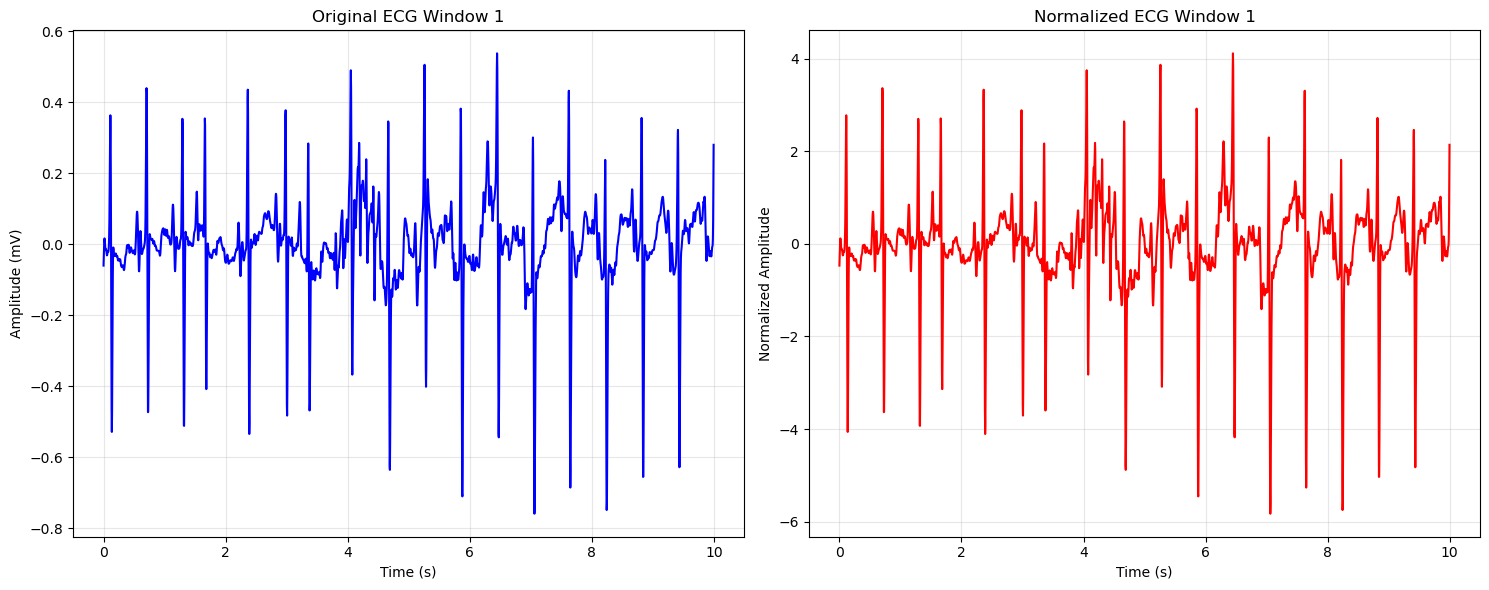

In [11]:
def plot_normalization_example(original_windows, normalized_windows, num_examples=2, fs=128):
    """
    Plot contoh ECG window sebelum dan sesudah normalisasi
    """
    plt.figure(figsize=(15, 6))
    
    for i in range(num_examples):
        # Ambil window ke-i
        raw_window = original_windows[i]
        norm_window = normalized_windows[i]
        time_axis = np.arange(len(raw_window)) / fs  # buat sumbu waktu dalam detik
        
        # Plot sebelum normalisasi
        plt.subplot(num_examples, 2, 2*i + 1)
        plt.plot(time_axis, raw_window, color='b')
        plt.title(f"Original ECG Window {i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (mV)")
        plt.grid(True, alpha=0.3)
        
        # Plot sesudah normalisasi
        plt.subplot(num_examples, 2, 2*i + 2)
        plt.plot(time_axis, norm_window, color='r')
        plt.title(f"Normalized ECG Window {i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalized Amplitude")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Contoh pemanggilan
plot_normalization_example(ecg_windows, normalized_windows, num_examples=1, fs=processed_fs)

POTONG SINYAL UNTUK DIJADIKAN INPUT GUI (TESTING)

In [12]:
# def save_segment_as_wfdb(signal_segment, record_name, output_dir, fs=250):
#     print(f"  💾 Saving {record_name}...")
    
#     # Create output directory jika belum ada
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Reshape signal untuk WFDB (harus 2D: samples x channels)
#     signal_2d = signal_segment.reshape(-1, 1)
    
#     # Save sebagai WFDB record
#     wfdb.wrsamp(
#         record_name=record_name,
#         fs=fs,
#         units=['mV'],
#         sig_name=['ECG'],
#         p_signal=signal_2d,
#         write_dir=output_dir
#     )
    
#     print(f"  ✅ Saved: {os.path.join(output_dir, record_name)}.dat")
#     print(f"  ✅ Saved: {os.path.join(output_dir, record_name)}.hea")
#     print(f"     Duration: {len(signal_segment)/fs:.2f} seconds")
#     print(f"     Samples: {len(signal_segment)}")


# def extract_and_save_test_segments(clean_ecg, segments, fs, output_dir):
#     """
#     Extract 2 segment AF dan 2 segment Normal dari data preprocessed
#     lalu save sebagai file WFDB untuk testing GUI
    
#     Parameters:
#     -----------
#     clean_ecg : array
#         Concatenated clean ECG signal (sudah filtered)
#     segments : list
#         List of segment dictionaries dengan labels
#     fs : int
#         Sampling rate
#     output_dir : str
#         Output directory
#     """
    
#     print("="*70)
#     print("🔧 EXTRACTING TEST SEGMENTS FROM PREPROCESSED DATA")
#     print("="*70)
#     print(f"\n📂 Output directory: {output_dir}\n")
    
#     # Pisahkan AF dan Normal segments
#     af_segments = [seg for seg in segments if seg['label'] == 1]  # AF = 1
#     normal_segments = [seg for seg in segments if seg['label'] == 0]  # Normal = 0
    
#     print(f"Available segments:")
#     print(f"  AF segments: {len(af_segments)}")
#     print(f"  Normal segments: {len(normal_segments)}")
    
#     if len(af_segments) < 2:
#         print(f"⚠️  Warning: Only {len(af_segments)} AF segments available")
#     if len(normal_segments) < 2:
#         print(f"⚠️  Warning: Only {len(normal_segments)} Normal segments available")
    
#     # Track current position dalam concatenated signal
#     segment_positions = []
#     current_pos = 0
    
#     for seg in segments:
#         seg_length = seg['end_sample'] - seg['start_sample']
#         segment_positions.append({
#             'start': current_pos,
#             'end': current_pos + seg_length,
#             'label': seg['label'],
#             'duration': seg['duration_sec'],
#             'original_info': seg
#         })
#         current_pos += seg_length
    
#     # ========================================
#     # Extract AF segments
#     # ========================================
#     print("\n🔴 EXTRACTING AF SEGMENTS")
#     print("-" * 70)
    
#     af_count = 0
#     for i, pos in enumerate(segment_positions):
#         if pos['label'] == 1 and af_count < 2:  # AF
#             af_count += 1
            
#             # Extract signal segment
#             signal_segment = clean_ecg[pos['start']:pos['end']]
            
#             # Ambil potongan 10 detik dari segment ini (jika lebih panjang)
#             max_samples = int(60 * fs)  # 60 detik
#             if len(signal_segment) > max_samples:
#                 signal_segment = signal_segment[:max_samples]
            
#             record_name = f"af_{af_count:03d}"
            
#             print(f"\n[AF {af_count}/2]")
#             print(f"  Segment index: {i}")
#             print(f"  Duration: {pos['duration']:.2f} seconds")
#             print(f"  Samples: {len(signal_segment)}")
#             print(f"  Original rhythm: {pos['original_info']['rhythm_label']}")
            
#             save_segment_as_wfdb(signal_segment, record_name, output_dir, fs)
    
#     # ========================================
#     # Extract Normal segments
#     # ========================================
#     print("\n🟢 EXTRACTING NORMAL SEGMENTS")
#     print("-" * 70)
    
#     normal_count = 0
#     for i, pos in enumerate(segment_positions):
#         if pos['label'] == 0 and normal_count < 2:  # Normal
#             normal_count += 1
            
#             # Extract signal segment
#             signal_segment = clean_ecg[pos['start']:pos['end']]
            
#             # Ambil potongan 10 detik dari segment ini (jika lebih panjang)
#             max_samples = int(60 * fs)  # 10 detik
#             if len(signal_segment) > max_samples:
#                 signal_segment = signal_segment[:max_samples]
            
#             record_name = f"normal_{normal_count:03d}"
            
#             print(f"\n[Normal {normal_count}/2]")
#             print(f"  Segment index: {i}")
#             print(f"  Duration: {pos['duration']:.2f} seconds")
#             print(f"  Samples: {len(signal_segment)}")
#             print(f"  Original rhythm: {pos['original_info']['rhythm_label']}")
            
#             save_segment_as_wfdb(signal_segment, record_name, output_dir, fs)
    
#     # ========================================
#     # Summary
#     # ========================================
#     print("\n" + "="*70)
#     print("✅ SEGMENT EXTRACTION COMPLETED!")
#     print("="*70)
#     print(f"\n📊 Summary:")
#     print(f"   • AF segments extracted: {af_count}")
#     print(f"   • Normal segments extracted: {normal_count}")
#     print(f"   • Total files: {(af_count + normal_count) * 2}")  # .dat + .hea
#     print(f"   • Source: Record {record_id}, preprocessed")
#     print(f"   • Sampling rate: {fs} Hz")
#     print(f"   • Format: WFDB (.dat + .hea)")
#     print(f"   • Location: {output_dir}")
    
#     print(f"\n📁 Generated files:")
#     files = []
#     for i in range(1, af_count + 1):
#         files.extend([f"af_{i:03d}.dat", f"af_{i:03d}.hea"])
#     for i in range(1, normal_count + 1):
#         files.extend([f"normal_{i:03d}.dat", f"normal_{i:03d}.hea"])
    
#     for f in files:
#         filepath = os.path.join(output_dir, f)
#         if os.path.exists(filepath):
#             size = os.path.getsize(filepath)
#             print(f"   ✅ {f} ({size:,} bytes)")
#         else:
#             print(f"   ❌ {f} (NOT FOUND)")
    
#     print("\n" + "="*70)
#     print("🎯 Ready to test GUI!")
#     print("="*70)
#     print("\nTest dengan GUI:")
#     print("1. Run: python main.py")
#     print("2. Load af_001.dat → Should predict 'AF'")
#     print("3. Load normal_001.dat → Should predict 'Normal'")
#     print("\nFile ini adalah REAL ECG segments dari MIT-BIH AFDB,")
#     print("bukan synthetic data, jadi lebih akurat untuk testing!")
#     print("\n" + "="*70 + "\n")


# # ========================================
# # JALANKAN EXTRACTION
# # ========================================

# # Pastikan variabel ini sudah ada dari cell sebelumnya:
# # - clean_ecg: concatenated signal yang sudah filtered
# # - segments: list of segments dengan labels
# # - processed_fs: sampling rate
# # - record_id: record identifier

# if 'clean_ecg' in globals() and 'segments' in globals():
#     output_dir = r"D:\skripsi_teknis\af_detection_gui\dataset_dummy"
    
#     extract_and_save_test_segments(
#         clean_ecg=clean_ecg,
#         segments=segments,
#         fs=processed_fs,  # Gunakan sampling rate original (akan di-resample di GUI)
#         output_dir=output_dir
#     )
# else:
#     print("❌ Error: Required variables not found!")
#     print("Make sure you have run all previous cells to create:")
#     print("  - clean_ecg")
#     print("  - segments")
#     print("  - processed_fs")
#     print("  - record_id")